In [1]:
import os
import sys

In [2]:
import pandas as pd
from scipy import stats

In [3]:
from importlib import reload
import time
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from enviserv.dictan import DictAnalyzer # анализ словарей
import pandserv as pds # форматирование небольших пандас ДФ

In [6]:
from sparkserv import SparkApp, Cols
# в SparkApp упакованы функции создания спарк приложения 
# с определением IP мастер-ноды и с подключением к кластеру

# Col - класс для формирования коротких псевдонимов имен столбцов
# при этом исходные имена полей не меняются

In [7]:
import pyspark.sql.functions as f

### Создание сессии, загрузка данных

In [8]:
spark_app = SparkApp(my_logger_create_level = 'INFO')

INFO:spark_app:spark_master_ip: 172.18.0.2
INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7fc80f7ca950>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [9]:
spark_master_ip = spark_app.get_spark_master_ip()
# print(spark_master_ip)

INFO:spark_app:spark_master_ip: 172.18.0.2


In [10]:
# spark = spark_app.build_spark_app(spark_master_ip=spark_master_ip)
spark = spark_app.spark

Для корректного завершения спарк-сессии (напрмер, для переключения между ноутбуками) следует останавливать сессию полностью. Для этого использую метод .stop_spark_app() класса SparkApp

In [11]:
spark_app.stop_spark_app()

INFO:spark_app:attempt to stop SparkSession app object
INFO:spark_app:.stop() instruction has been executed
INFO:spark_app:attempt to create new SparkSession app object after stopping


'stopped'

In [13]:
print(spark_app.spark)

None


In [14]:
spark_app.build_spark_app()

INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7fc80f801190>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [15]:
spark = spark_app.spark

In [16]:
%%time
taxi = spark.read.load('/work/data/Taxi_Trips_-_2022.csv', 
                       format='csv', header='true', inferSchema='true')

CPU times: user 6.41 ms, sys: 10.3 ms, total: 16.7 ms
Wall time: 38 s


In [17]:
# taxi_rdd = spark.sparkContext.textFile('/work/data/Taxi_Trips_-_2022.csv')
# taxi_rdd.take(2)

In [18]:
# taxi.printSchema()

In [19]:
# создадим объект для представления имен полей
ct = Cols(taxi)

ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

In [20]:
pd.set_option('display.max_colwidth', None)

In [21]:
table_descr = pd.read_csv('/work/data/table_descr.csv',sep=';',index_col='Column Name')

table_descr

,Description,Type,Описание,Тип
Column Name,,,,
Trip ID,A unique identifier for the trip.,Plain Text,Уникальный идентификатор поездки,Обычный текст
Taxi ID,A unique identifier for the taxi.,Plain Text,Уникальный идентификатор такси,Обычный текст
Trip Start Timestamp,When the trip started rounded to the nearest 15 minutes.,Date & Time,Время начала поездки округленное до ближайших 15 минут,Дата и время
Trip End Timestamp,When the trip ended rounded to the nearest 15 minutes.,Date & Time,Время окончания поездки округленное до ближайших 15 минут,Дата и время
Trip Seconds,Time of the trip in seconds.,Number,Продолжительность поездки в секундах,Число
Trip Miles,Distance of the trip in miles.,Number,Расстояние поездки в милях,Число
Pickup Census Tract,The Census Tract where the trip began. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где началась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Dropoff Census Tract,The Census Tract where the trip ended. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где завершилась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Pickup Community Area,The Community Area where the trip began. This column will be blank for locations outside Chicago.,Number,Номер коммунальной области где началась поездка. Это поле остается пустым для мест за пределами Чикаго.,Число


In [22]:
pd.reset_option('display.max_colwidth')  # Сброс максимальной ширины столбцов к значению по умолчанию

### Описание "Census Tract" и "Community Area"

Поля "Census Tract" и "Community Area" представляют собой два различных уровня административных единиц:

**Census Tract:**  
Это статистические единицы, используемые в переписи населения в США, проводимой каждые 10 лет.
Census Tract обычно представляют собой географические области, населенные от 1 200 до 8 000 человек.
Они предназначены для обеспечения стандартизированных данных для анализа населения, доходов, расового и этнического состава и других социально-экономических параметров.

Далее для краткости буду называть данную адм.единицу - **Квартал**

**Community Area:**  
Это административные районы в городе Чикаго, разработанные городским правительством.
Community Areas используются для организации и управления городскими службами и ресурсами.
Обычно Community Areas выступают в качестве единиц анализа для изучения социальных и экономических показателей, таких как уровень преступности, доступность образования и здравоохранения и др.

Далее для краткости буду называть данную адм.единицу - **Район**

Community Area представляют собой административные районы, охватывающие большие части города, в то время как Census Tract более мелкие географические области, которые могут быть распределены по всему Community Area. Таким образом, Community Area охватывает несколько Census Tract и представляет собой более крупную административную единицу.

В идеальной ситуации каждый Census Tract должен быть частью только одной Community Area, чтобы избежать перекрытий и дублирования данных. Однако в реальности могут быть исключения из-за изменений границ административных районов или других факторов.

In [23]:
# %%time
# describe_result = taxi.describe().toPandas()

# time cost for i5 (7g), 4 workers (x) 2gb RAM 
# CPU times: user 352 ms, sys: 32.2 ms, total: 384 ms
# Wall time: 2min 7s

In [24]:
# output_file_path = '/work/data/2022_describe.csv'
# describe_result.to_csv(output_file_path, index=False) #transpose().

Импортируем сохраненную таблицу-описание данных `.describe()`

In [25]:
dr = pd.read_csv('/work/data/2022_describe.csv',sep=',',index_col='summary')

In [26]:
drf = dr.copy()
#  отформатируем таблицу описания
pds.get_df_formated(drf, '`',2, 10)

In [27]:
drf.transpose()

summary,count,mean,stddev,min,max
Trip ID,6`382`425,nan,nan,000000bb18,ffffff1aae
Taxi ID,6`382`425,nan,nan,0041f8f0c9,fff84aa08a
Trip Start Timestamp,6`382`425,nan,nan,01/01/2022,12/31/2022
Trip End Timestamp,6`382`213,nan,nan,01/01/2022,12/31/2022
Trip Seconds,6`380`960,1`198.21,1`895.66,0,86`341
Trip Miles,6`382`369,6.19,8.00,0,2`967.54
Pickup Census Tract,2`623`831,17`031`468`160.38,368`945.90,17`031`010`100,17`031`980`100
Dropoff Census Tract,2`675`331,17`031`411`846.86,345`773.49,17`031`010`100,17`031`980`100
Pickup Community Area,5`868`572,32.35,25.20,1,77
Dropoff Community Area,5`748`741,25.84,20.93,1,77


In [28]:
# val = int(dr.transpose()['count'].astype(float).max())
# print(pds.gvf(val))

In [29]:
%%time
row_count = taxi.count()

# time cost i5 (7g), 4 workers (x) 2gb RAM
# CPU times: user 5.85 ms, sys: 871 µs, total: 6.72 ms
# Wall time: 11.8 s

CPU times: user 0 ns, sys: 8.83 ms, total: 8.83 ms
Wall time: 12.2 s


In [30]:
print(pds.gvf(row_count))

6'382'425


### Оценим количество пропусков

In [31]:
drt = dr.transpose()
drt['count'] = drt['count'].astype(int)
drt['not_null_ratio']=drt['count']/row_count

drt = drt[['count','not_null_ratio']]

# отображение отформатированных данных
pds.get_df_formated(drt,'`',4, 10)

display(drt)

print('============================================')
print('=== columns count ==================',int(len(drt)),'====')
print('============================================')

summary,count,not_null_ratio
Trip ID,6`382`425,1
Taxi ID,6`382`425,1
Trip Start Timestamp,6`382`425,1
Trip End Timestamp,6`382`213,1.0000
Trip Seconds,6`380`960,0.9998
Trip Miles,6`382`369,1.0000
Pickup Census Tract,2`623`831,0.4111
Dropoff Census Tract,2`675`331,0.4192
Pickup Community Area,5`868`572,0.9195
Dropoff Community Area,5`748`741,0.9007


=== columns count ================== 23 ====


Видим, что  
- 7 полей не содержат пропусков, в т.ч 2 почти их не имеют;
- 8 полей заполнены более чем на 99%;
- `Pickup Census Tract`, `Dropoff Census Tract` заполнены менее, чем на 50%;
- соответствующие поля с геоданными заполнены более, чем на 90%

Поскольку прогноз строится для кварталов, следует связать поля геоданных и кварталов. Попробую заполнить пропуски. В случае невозможности заполненения пропусков для кварталов, в качестве ключа-аггрегатора буду использовать геоточки.

### Ключи-агрегаторы

В качестве ключа предполагается использовать кортеж-тройку (код квартала, широта, долгота)

Проверю взаимнооднозначность множеств кварталов и геоточек (для непустых зачений)

In [69]:
# ctp - pickup census tract
ctp = taxi.groupBy(ct.pickup_ct).count().orderBy("count", ascending=False).cache()
ctp.show(5)
ctp_count = ctp.filter(ctp[ct.pickup_ct].isNotNull()).count()
print('============================================')
print('pickup ct count:',ctp_count)

+-------------------+-------+
|Pickup Census Tract|  count|
+-------------------+-------+
|               null|3758594|
|        17031980000| 519802|
|        17031320100| 304178|
|        17031839100| 284131|
|        17031281900| 188178|
+-------------------+-------+
only showing top 5 rows

pickup ct count: 665


In [70]:
# ctd - dropoff census tract
ctd = taxi.groupBy(ct.dropoff_ct).count().orderBy("count", ascending=False).cache()
ctd.show(5)
ctd_count = ctd.filter(ctd[ct.dropoff_ct].isNotNull()).count()
print('============================================')
print('dropoff ct count:',ctd_count)

+--------------------+-------+
|Dropoff Census Tract|  count|
+--------------------+-------+
|                null|3707094|
|         17031839100| 328855|
|         17031320100| 277879|
|         17031980000| 243652|
|         17031081500| 160251|
+--------------------+-------+
only showing top 5 rows

dropoff ct count: 811


In [77]:
ctd.filter(ctd[ct.dropoff_ct].isNotNull()).\
join(ctp.filter(ctp[ct.pickup_ct].isNotNull()),\
     ctd[ct.dropoff_ct]==ctp[ct.pickup_ct],'left_anti').count()

180

In [61]:
%%time
# список уникальных троек
f1 = ct.pickup_ct # 'Pickup Census Tract'
f2 = ct.pickup_cl # 'Pickup Centroid Latitude'
f3 = ct.pickup_clon # 'Pickup Centroid Longitude'
pckgeo = taxi.select(f1, f2, f3).distinct().collect()

CPU times: user 23.1 ms, sys: 2.31 ms, total: 25.4 ms
Wall time: 16.6 s


In [62]:
len(pckgeo)

743

In [63]:
pckgeo[:3]

[Row(Pickup Census Tract=17031351000, Pickup Centroid Latitude=41.834673598, Pickup Centroid Longitude=-87.610834737),
 Row(Pickup Census Tract=17031490400, Pickup Centroid Latitude=41.723821251, Pickup Centroid Longitude=-87.611845985),
 Row(Pickup Census Tract=17031831600, Pickup Centroid Latitude=41.925588088, Pickup Centroid Longitude=-87.797600684)]

In [64]:
len([row for row in pckgeo if row[f1] is None])

78

In [65]:
from collections import defaultdict

In [66]:
# Инициализация словаря для хранения значений
tract_to_coords = defaultdict(list)

# Заполнение словаря
for row in tqdm(pckgeo):
    tract = row[f1]
    coords = (row[f3], row[f2])
    tract_to_coords[tract].append(coords)

# Поиск районов с разными значениями широты и долготы
repeated_tracts = {tract: coords for tract, coords in tract_to_coords.items() if len(set(coords)) > 1}

100%|██████████| 743/743 [00:00<00:00, 67468.45it/s]


In [67]:
# Вывод результатов
for tract, coords in repeated_tracts.items():
    print(f"Район: {tract}, Количетво геоточек: {len(coords)}")
    print()

# Количество таких районов
print(f"Количество районов с разными значениями широты и долготы: {len(repeated_tracts)}")

Район: None, Количетво геоточек: 78

Количество районов с разными значениями широты и долготы: 1


In [68]:
for geop in repeated_tracts[None]:
    if geop == (None,None): continue
    # print(f"geop {geop}")
    for tract, geos in tract_to_coords.items():
        if tract is None: continue
        if geop in geos:
            print(f"geopoint: {geop} - {tract}")

geopoint: (-87.596475596, 41.728182061) - 17031470100


In [69]:
# tract_to_coords

In [70]:
%%time
geos_pck = taxi.select(f2, f3).distinct().orderBy(f2, f3).collect()

CPU times: user 25.4 ms, sys: 1.55 ms, total: 27 ms
Wall time: 17.7 s


In [71]:
len(geos_pck)

616

In [72]:
geos_pck[:5]

[Row(Pickup Centroid Latitude=None, Pickup Centroid Longitude=None),
 Row(Pickup Centroid Latitude=41.651921576, Pickup Centroid Longitude=-87.564929171),
 Row(Pickup Centroid Latitude=41.660136051, Pickup Centroid Longitude=-87.60284764),
 Row(Pickup Centroid Latitude=41.663670652, Pickup Centroid Longitude=-87.540935513),
 Row(Pickup Centroid Latitude=41.663759731, Pickup Centroid Longitude=-87.637304085)]

In [73]:
%%time
f2 = 'Pickup Centroid Latitude'
f3 = 'Pickup Centroid Longitude'
geos_pck_not_null = taxi.select(f2, f3).filter(taxi[f2].isNotNull() &
                taxi[f3].isNotNull()).distinct().orderBy(taxi[f2].asc(), taxi[f3].asc()).collect()

CPU times: user 25.2 ms, sys: 8.61 ms, total: 33.8 ms
Wall time: 16.3 s


In [74]:
geos_pck_not_null[:5]

[Row(Pickup Centroid Latitude=41.651921576, Pickup Centroid Longitude=-87.564929171),
 Row(Pickup Centroid Latitude=41.660136051, Pickup Centroid Longitude=-87.60284764),
 Row(Pickup Centroid Latitude=41.663670652, Pickup Centroid Longitude=-87.540935513),
 Row(Pickup Centroid Latitude=41.663759731, Pickup Centroid Longitude=-87.637304085),
 Row(Pickup Centroid Latitude=41.665167734, Pickup Centroid Longitude=-87.535284961)]

In [75]:
%%time
geos_pck_not_null = taxi.select(f2, f3).filter(taxi[f2].isNull() &
                taxi[f3].isNull()).collect()

CPU times: user 3.63 s, sys: 83.9 ms, total: 3.71 s
Wall time: 18.7 s


In [76]:
%%time
geos_pck_not_null = taxi.select(f2, f3).filter(taxi[f2].isNull() & taxi[f3].isNull())

CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 188 ms


In [77]:
%%time
print(pds.gvf(geos_pck_not_null.count()))

511'551
CPU times: user 0 ns, sys: 8.27 ms, total: 8.27 ms
Wall time: 14.3 s


In [78]:
%%time
taxi.select(f2, f3).filter(taxi[f2].isNull() &
                taxi[f3].isNotNull()).count()

CPU times: user 13.2 ms, sys: 268 µs, total: 13.5 ms
Wall time: 14.3 s


0

In [79]:
%%time
taxi.select(f2, f3).filter(taxi[f2].isNotNull() &
                taxi[f3].isNull()).count()

CPU times: user 18.5 ms, sys: 177 µs, total: 18.6 ms
Wall time: 14.7 s


0

In [80]:
taxi.select(ct.pickup_ca).distinct().count()

78

In [81]:
taxi.select(ct.dropoff_ca).distinct().count()

78

### Частоты "Census Tract"

In [32]:
# Функция для вычисления частот
def frq(df, column):
    # Вычисляем частоту для каждого значения
    freq_df = df.groupBy(column).count().orderBy("count", ascending=False)
    freq_df = freq_df.withColumn("ratio", freq_df["count"]/row_count)
    return freq_df

In [33]:
%%time
pct_frq = frq(taxi,ct.pickup_ct)

pct_frq_list = [list(t) for t in \
                zip(*[[str(row[ct.pickup_ct]), row['ratio']] \
                      for row in pct_frq.collect()])]

CPU times: user 48.5 ms, sys: 3.36 ms, total: 51.9 ms
Wall time: 18.7 s


Как указал выше, пустых значений для кварталов более половины

In [34]:
[pct_frq_list[0][0], pds.gvf(pct_frq_list[1][0],"'",3)]

['None', '0.589']

Посмотрим распределение для непустых значений первых 30-ти самых активных кварталов посадки

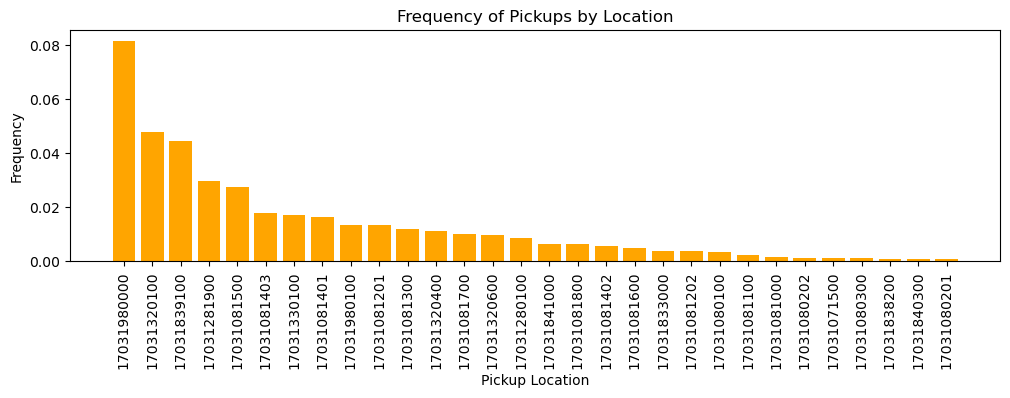

In [35]:
# Построение бар-графика
# Преобразование значений оси X в строки
x_values = [str(x) for x in pct_frq_list[0][1:31]]
y_values = pct_frq_list[1][1:31]

plt.figure(figsize=(12, 3))
plt.bar(range(len(x_values)), y_values, color='orange')
plt.xlabel('Pickup Location')
plt.ylabel('Frequency')
plt.title('Frequency of Pickups by Location')
plt.xticks(range(len(x_values)), x_values, rotation=90)

plt.show()

In [31]:
%%time
dct_frq = frq(taxi,ct.dropoff_ct)
dct_frq.show()

+--------------------+-------+--------------------+
|Dropoff Census Tract|  count|               ratio|
+--------------------+-------+--------------------+
|                null|3707094|  0.5808284468677658|
|         17031839100| 328855| 0.05152508646791776|
|         17031320100| 277879|0.043538153601491596|
|         17031980000| 243652|  0.0381754583876818|
|         17031081500| 160251|0.025108168133585587|
|         17031330100| 139399|0.021841071379608848|
|         17031081403| 133973| 0.02099092429601601|
|         17031281900| 129117| 0.02023008495987027|
|         17031081700| 114125|0.017881134521753096|
|         17031081401| 100596|0.015761407302083457|
|         17031081201|  87949|0.013779872070568789|
|         17031833000|  83912|0.013147353866281233|
|         17031320400|  81112|0.012708649141979734|
|         17031081800|  76118|0.011926187930136273|
|         17031081300|  75221|0.011785645738101114|
|         17031280100|  67209|0.010530323505564107|
|         17

In [32]:
spark_app.stop_spark_app()

INFO:spark_app:attempt to stop SparkSession app object
INFO:spark_app:.stop() instruction has been executed
INFO:spark_app:attempt to create new SparkSession app object after stopping


'stopped'

In [33]:
%%time
pca_frq = frq(taxi,ct.pickup_ca)
pca_frq.show()

RuntimeError: SparkContext or SparkSession should be created first.

### Уникальные значения для "Census Tract"

In [36]:
def compare_unique_values(df, field1, field2):
    # Извлекаем уникальные значения для каждого поля
    unique_values_field1 = df.select(field1).distinct().collect()
    unique_values_field2 = df.select(field2).distinct().collect()
    
    # Преобразуем результаты в множества
    set_field1 = {row[field1] for row in unique_values_field1}
    set_field2 = {row[field2] for row in unique_values_field2}
    
    # Находим значения, которые есть в set_field1, но нет в set_field2
    only_in_field1 = {value for value in set_field1 if value not in set_field2}
    
    # Находим значения, которые есть в set_field2, но нет в set_field1
    only_in_field2 = {value for value in set_field2 if value not in set_field1}
    
    return only_in_field1, only_in_field2, set_field1, set_field2

In [37]:
%%time
only_pickup, only_dropoff, pickup, dropoff = \
compare_unique_values(taxi, ct.pickup_ct,ct.dropoff_ct)

CPU times: user 50.4 ms, sys: 21.3 ms, total: 71.7 ms
Wall time: 33.1 s


In [38]:
print('`Pickup Census Tract` distinct count:',len(pickup), ' | only in pickup set:',len(only_pickup))
print('`Dropoff Census Tract` distinct count:',len(dropoff), ' | only in dropoff set:',len(only_dropoff))

`Pickup Census Tract` distinct count: 666  | only in pickup set: 34
`Dropoff Census Tract` distinct count: 812  | only in dropoff set: 180


In [82]:
ct.testtt()

*******-------------*******


In [83]:
ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

In [84]:
taxi.take(1)

[Row(Trip ID='bcfa19f2539021c054809d4c3993d226996ae095', Taxi ID='368ce5511598af2cc07efdb68067d381174fdac1d47a2837d021e647f4c8febb3d9bf330e155845b8217b9b451c29b1b9ecf5d55d4bfe6cfd5d79ffb49b1f334', Trip Start Timestamp='01/01/2022 12:00:00 AM', Trip End Timestamp='01/01/2022 12:00:00 AM', Trip Seconds=152, Trip Miles=0.1, Pickup Census Tract=None, Dropoff Census Tract=None, Pickup Community Area=None, Dropoff Community Area=None, Fare=3.75, Tips=0.0, Tolls=0.0, Extras=0.0, Trip Total=3.75, Payment Type='Cash', Company='Medallion Leasin', Pickup Centroid Latitude=None, Pickup Centroid Longitude=None, Pickup Centroid Location=None, Dropoff Centroid Latitude=None, Dropoff Centroid Longitude=None, Dropoff Centroid  Location=None)]

In [85]:
taxi.filter(taxi[ct.trip_m]>10).count()

1777033

In [86]:
long = taxi.filter((taxi[ct.trip_m]>9.9) & (taxi[ct.trip_m]<10.1) 
                   & taxi[ct.pickup_cl].isNotNull() & taxi[ct.dropoff_cl].isNotNull() 
                   & taxi[ct.pickup_clon].isNotNull() & taxi[ct.dropoff_clon].isNotNull()
                  )

In [87]:
long.count()

20855

In [88]:
long = long.withColumn('Distance',(
                                ((taxi[ct.pickup_cl]-taxi[ct.dropoff_cl])**2 +
                                (taxi[ct.pickup_clon]-taxi[ct.dropoff_clon])**2))**0.5)

In [89]:
%%time
long.select(ct.pickup_cl,ct.dropoff_cl,ct.pickup_clon,ct.dropoff_clon,'Distance').take(10)

CPU times: user 6.84 ms, sys: 9.91 ms, total: 16.7 ms
Wall time: 242 ms


[Row(Pickup Centroid Latitude=41.901206994, Dropoff Centroid Latitude=41.901206994, Pickup Centroid Longitude=-87.676355989, Dropoff Centroid Longitude=-87.676355989, Distance=0.0),
 Row(Pickup Centroid Latitude=41.874005383, Dropoff Centroid Latitude=41.9867118, Pickup Centroid Longitude=-87.66351755, Dropoff Centroid Longitude=-87.663416405, Distance=0.11270646238477244),
 Row(Pickup Centroid Latitude=41.899602111, Dropoff Centroid Latitude=41.839086906, Pickup Centroid Longitude=-87.633308037, Dropoff Centroid Longitude=-87.714003807, Distance=0.10086573913913337),
 Row(Pickup Centroid Latitude=41.857183858, Dropoff Centroid Latitude=41.9867118, Pickup Centroid Longitude=-87.620334624, Dropoff Centroid Longitude=-87.663416405, Distance=0.1365046798204703),
 Row(Pickup Centroid Latitude=41.874005383, Dropoff Centroid Latitude=41.857183858, Pickup Centroid Longitude=-87.66351755, Dropoff Centroid Longitude=-87.620334624, Distance=0.046343595040167315),
 Row(Pickup Centroid Latitude=41

## UDF

#### Пример UDF (с устаревшим способом указания типа UDF)
для возврата значения функции норм.распределения вер-ти для 1М случайных значений

In [90]:
%%time

from scipy import stats

big_df = (
    spark
    .range(0, 1_000_000)
    .withColumn('val',f.rand())
)

big_df.cache()
big_df.show(3)

@f.pandas_udf('double', f.PandasUDFType.SCALAR)
def pandas_pdf(v):
    return pd.Series(stats.norm.pdf(v))

(
    big_df
    .withColumn('probability', pandas_pdf(big_df.val))
    .show(5)
)

+---+------------------+
| id|               val|
+---+------------------+
|  0|0.6627121395028065|
|  1|0.7992250359037549|
|  2|0.5431878775820032|
+---+------------------+
only showing top 3 rows



/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+---+------------------+-------------------+
| id|               val|        probability|
+---+------------------+-------------------+
|  0|0.6627121395028065| 0.3202887894528127|
|  1|0.7992250359037549| 0.2898711218445793|
|  2|0.5431878775820032|0.34422317467295227|
|  3|0.3136391980518072| 0.3797951287627703|
|  4| 0.887399732086023| 0.2690985322764769|
+---+------------------+-------------------+
only showing top 5 rows

CPU times: user 321 ms, sys: 39.4 ms, total: 361 ms
Wall time: 3.15 s


Предупреждение  
`/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn`  

связано с устареванием способа указания типа UDF (User Defined Function) в PySpark. Сообщение указывает на то, что начиная с Python 3.6 и Spark 3.0, предпочтительно использовать аннотации типов вместо указания типа UDF через параметр f.PandasUDFType.

Конкретно предупреждение означает, что метод указания типа UDF через f.PandasUDFType.SCALAR будет устаревшим в будущих версиях PySpark, и рекомендуется использовать аннотации типов для Pandas UDF. Это сделано для повышения ясности кода и его поддерживаемости

В `@f.pandas_udf('double', f.PandasUDFType.SCALAR)`
- первый параметр `'double'` указывает тип возвращаемого значения ЮДФ,
- второй параметр - это тип функции. Если возвращается один столбец (`.Series(...)`), используется `.PandasUDFType.SCALAR`, если возвращается несколько столбцов (pandas `DataFrame(...)`), `.PandasUDFType.GROUPED_MAP`

### Пример UDF (аргумент - Series) с аннотацией типов

In [91]:
%%time
from pyspark.sql.types import DoubleType

big_df = (
    spark
    .range(0, 1_000_000)
    .withColumn('val', f.rand())
)

big_df.cache()
big_df.show(3)

@f.pandas_udf(DoubleType())
def pandas_pdf(v: pd.Series) -> pd.Series:
    return pd.Series(stats.norm.pdf(v))

result = big_df.withColumn('pdf', pandas_pdf(f.col('val')))
result.show(3)

+---+------------------+
| id|               val|
+---+------------------+
|  0|0.9313134857540163|
|  1|0.6350425702139387|
|  2| 0.520918598957538|
+---+------------------+
only showing top 3 rows

+---+------------------+-------------------+
| id|               val|                pdf|
+---+------------------+-------------------+
|  0|0.9313134857540163|0.25856428335881904|
|  1|0.6350425702139387| 0.3260912378075341|
|  2| 0.520918598957538|0.34832594062084027|
+---+------------------+-------------------+
only showing top 3 rows

CPU times: user 23.6 ms, sys: 1.26 ms, total: 24.9 ms
Wall time: 2.47 s


Здесь `DoubleType()` используется вместо `f.PandasUDFType.SCALAR`, и типы указаны непосредственно в аннотациях функции `(v: pd.Series) -> pd.Series`. Это улучшает читаемость кода и соответствует новым стандартам PySpark.

В актуальном способе указания типов для PySpark UDF для определения UDF, которая возвращает несколько столбцов (pandas DataFrame), вы можете использовать аннотацию функции и указание типа возвращаемого значения при помощи PySpark StructType. В этом случае вам понадобится указать схему (schema), описывающую структуру возвращаемого DataFrame.

In [92]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

# Определяем схему возвращаемого DataFrame
schema = StructType([
    StructField("col1", DoubleType(), True),
    StructField("col2", StringType(), True)
])

# Определяем Pandas UDF
@pandas_udf(schema)
def my_udf(input_col: pd.Series) -> pd.DataFrame:
    # Ваш код для обработки DataFrame
    result = pd.DataFrame({
        "col1": input_col * 2,
        "col2": input_col.astype(str)
    })
    return result

# Создаем DataFrame
df = spark.createDataFrame(
    [(1.0,), (2.0,), (3.0,)],
    ['input_col']
)

# Применяем UDF к столбцу
df.select(my_udf(df['input_col'])).show()

+-----------------+
|my_udf(input_col)|
+-----------------+
|       {2.0, 1.0}|
|       {4.0, 2.0}|
|       {6.0, 3.0}|
+-----------------+



Pandas UDF в PySpark может принимать несколько pandas Series объектов в качестве аргументов. Для этого необходимо использовать декоратор @pandas_udf и определить схему выходного DataFrame.

In [93]:
# Определяем схему выходного DataFrame
output_schema = StructType([
    StructField('output_col1', DoubleType()),
    StructField('output_col2', DoubleType())
])

# Определяем Pandas UDF с использованием декоратора @pandas_udf
@pandas_udf(output_schema)
def my_udf(input_col1: pd.Series, input_col2: pd.Series) -> pd.DataFrame:
    # Создаем DataFrame из двух входных Series
    output_df = pd.DataFrame({
        'output_col1': input_col1 + input_col2,
        'output_col2': input_col1 * input_col2
    })
    return output_df

# Создаем DataFrame для теста
df = spark.createDataFrame(
    [(1.0, 2.0), (3.0, 4.0), (5.0, 6.0)],
    ['input_col1', 'input_col2']
)

# Применяем Pandas UDF к DataFrame
result_df = df.select(my_udf(df['input_col1'], df['input_col2']))
result_df.show()

+------------------------------+
|my_udf(input_col1, input_col2)|
+------------------------------+
|                    {3.0, 2.0}|
|                   {7.0, 12.0}|
|                  {11.0, 30.0}|
+------------------------------+



### Пример UDF (аргумент - DataFrame) с аннотацией типов

Вы можете передать в UDF аргумент в виде DataFrame, но это будет работать только с UDF типа GROUPED_MAP. В этом случае каждый входной DataFrame будет представлять собой группу данных, по которой будет выполняться UDF. Для этого типа UDF вам необходимо определить схему входного DataFrame и схему выходного DataFrame.

In [94]:
# Определяем схему входного DataFrame
input_schema = StructType([
    StructField("col1", DoubleType(), True),
    StructField("col2", DoubleType(), True)
])

# Определяем схему возвращаемого DataFrame
output_schema = StructType([
    StructField("col1", DoubleType(), True),
    StructField("col2", DoubleType(), True),
    StructField("col3", StringType(), True)
])

# Определяем Pandas UDF типа GROUPED_MAP
@pandas_udf(output_schema, f.PandasUDFType.GROUPED_MAP)
def my_udf(pdf: pd.DataFrame) -> pd.DataFrame:
    # Ваш код для обработки DataFrame
    pdf["col3"] = (pdf["col1"] + pdf["col2"]).astype(str)
    return pdf

# Создаем DataFrame
df = spark.createDataFrame(
    [(1.0, 2.0), (3.0, 4.0), (5.0, 6.0)],
    ['col1', 'col2']
)

# Применяем UDF к DataFrame с использованием groupBy и apply
# В данном случае мы используем groupBy().apply() даже без явного группирования
df.groupBy().apply(my_udf).show()

/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/group_ops.py:103: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+----+----+----+
|col1|col2|col3|
+----+----+----+
| 3.0| 4.0| 7.0|
| 1.0| 2.0| 3.0|
| 5.0| 6.0|11.0|
+----+----+----+



Возможное предупреждение  
`/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/group_ops.py:103: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(`  
говорит о том, что используется устаревший способ `df.groupBy().apply(my_udf).show()`. Pandas UDFs с использованием `applyInPandas` предоставляют более современный и предпочтительный способ обработки pandas DataFrame.

Pandas UDF в режиме GROUPED_MAP не поддерживает передачу нескольких pandas DataFrame в качестве отдельных аргументов. Вместо этого вы должны объединить данные в один DataFrame до передачи в функцию. В режиме SCALAR Pandas UDF может принимать несколько Series в качестве аргументов.

Для использования нескольких pandas DataFrame в Pandas UDF с декоратором @pandas_udf в режиме GROUPED_MAP, вам нужно объединить два DataFrame в один перед тем, как вызывать функцию. PySpark Pandas UDF с типом GROUPED_MAP ожидает один pandas DataFrame в качестве аргумента

In [95]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType

# Определяем схему выходного DataFrame
output_schema = StructType([
    StructField('id', IntegerType()),
    StructField('output_col1', DoubleType()),
    StructField('output_col2', DoubleType())
])

# Определяем Pandas UDF с использованием декоратора @pandas_udf
@pandas_udf(output_schema, f.PandasUDFType.GROUPED_MAP)
def my_udf(pdf: pd.DataFrame) -> pd.DataFrame:
    # Создаем выходной DataFrame
    output_df = pd.DataFrame({
        'id': pdf['id'],
        'output_col1': pdf['input_col1'] + pdf['input_col2'],
        'output_col2': pdf['input_col1'] * pdf['input_col2']
    })
    return output_df

# Создаем два DataFrame для теста
df1 = spark.createDataFrame(
    [(1, 1.0), (2, 3.0), (3, 5.0)],
    ['id', 'input_col1']
)

df2 = spark.createDataFrame(
    [(1, 2.0), (2, 4.0), (3, 6.0)],
    ['id', 'input_col2']
)

# Объединяем два DataFrame по столбцу 'id'
df = df1.join(df2, on='id')

# Применяем Pandas UDF к DataFrame с использованием groupBy
result_df = df.groupBy('id').apply(my_udf)
result_df.show()

+---+-----------+-----------+
| id|output_col1|output_col2|
+---+-----------+-----------+
|  1|        3.0|        2.0|
|  2|        7.0|       12.0|
|  3|       11.0|       30.0|
+---+-----------+-----------+



### Сравнение производительности векторизированой и не_ ЮДФ

In [96]:
big_df = (
    spark
    .range(0, 1_000_000)
    .withColumn('val',f.rand())
)

In [97]:
def test_pandas_pdf():
    return (
        big_df
        .withColumn('probability', pandas_pdf(big_df.val))
        .agg(f.count(f.col('probability')))
        .show()
    )

%timeit -n 1 test_pandas_pdf()

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

711 ms ± 346 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
#row-by-row version with Python-JVM conversion
@f.udf('double')
def pdf(v):
    return float(stats.norm.pdf(v))

def test_pdf():
    return (
        big_df
        .withColumn('probability', pdf(big_df.val))
        .agg(f.count(f.col('probability')))
        .show()
    )

%timeit -n 1 test_pdf()

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

+------------------+
|count(probability)|
+------------------+
|           1000000|
+------------------+

36.7 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Результат для векторизированной ЮДФ - 903 ms, против не_ - 34.4 s

Отличие приверно в 40 раз!

### Использование объектов pandas в Pandas UDF

В **Pandas UDF** (User Defined Function) с использование декоратора `@pandas_udf` в Spark DataFrame API, функция pandas_pdf принимает один или несколько pandas Series (DataFrame) объектов и возвращает pandas Series (DataFrame) объект. В этом случае, pandas_pdf принимает Series v (который представляет собой значения из столбца val в DataFrame) и возвращает Series, содержащий значения, вычисленные с использованием функции stats.norm.pdf().

Возвращая `pd.Series(stats.norm.pdf(v))`, мы создаем объект Pandas Series, который содержит значения, вычисленные с помощью функции `stats.norm.pdf()`, примененные к каждому элементу входного Series v. Это необходимо потому, что Spark использует PyArrow для обмена данными между JVM и Python, и PyArrow не может обрабатывать объекты `stats.norm.pdf(v)` напрямую, так как они не являются объектами pandas.

Поэтому, оборачивая результат stats.norm.pdf(v) в pd.Series(), мы создаем объект pandas, который Spark может обработать, и возвращаем его из функции pandas_pdf.

## .cache() .unpersist() - кэш памяти

Когда вы вызываете `big_df.cache()`, вы помещаете DataFrame big_df в **кэш памяти**. Это означает, что DataFrame будет кэширован в памяти и будет доступен для быстрого доступа к данным при последующих операциях.

Однако, если у вас есть ограничения на использование памяти или если кэш становится необходимым для других операций, вы можете явно удалить кэш с помощью метода `unpersist()`.

Это удалит кэш из памяти и освободит ресурсы, занимаемые DataFrame big_df. Если вы не удаляете кэш явно с помощью unpersist(), DataFrame останется в кэше и будет занимать память до тех пор, пока не будет удален Spark контекст или пока явно не будет вызвана операция `unpersist()`

In [99]:
big_df.unpersist()

DataFrame[id: bigint, val: double]

## Apache Arrow Memory & runtime switch

До версии ПиСпарк 2.3 использование ЮДФ в Питоне проигрывало по производительности Скале и Джаве (из-за переключений времени выполнения `runtime` между Питон и JVM).

С версии 2.3 Спарк начал использовать **Apache Arrow Memory** - общее пространство памяти для разных сред окружения, поэтому отпала необходимость и расходны на конвертацию объектов.

Также Arrow хранит в памяти **столбчатые объекты** (columnar objects), что повышает производительность. Используя это, ПиСпарк отрефакторилился, в результате чего мы получили **векторизированные ЮДФ**.

В аспектах программирования и операционных систем (в частности, процессов и потоков), термины "runtime" и "switch runtime" имеют разные значения. Давайте рассмотрим их подробнее:

**Runtime**  
**Программирование:**  
`Runtime` (время выполнения) - это фаза, когда программа исполняется. В это время происходят все динамические операции, такие как выполнение кода, управление памятью, обработка исключений и т.д. Например, в Python есть интерпретатор, который выполняет код во время исполнения программы.
`Runtime Environment` (среда выполнения) - это окружение, в котором исполняется программа. Оно включает в себя библиотеки, интерпретаторы (например, `Python Interpreter`) или виртуальные машины (например, `Java Virtual Machine`).  
**Процессы и потоки ОС:**  
`Runtime` в контексте ОС может также относиться к продолжительности времени, когда процесс или поток активен и выполняется на процессоре. Это время исполнения может включать в себя время, проведенное на процессоре, и время ожидания (например, ожидание ввода-вывода).

**Switch Runtime**  
**Программирование:**  
`Switch Runtime` (переключение времени выполнения) в программировании часто означает смену среды выполнения для кода. Например, если вы хотите исполнять код, написанный на Python, в среде JVM, это может потребовать использование специального инструмента или транслятора, который позволит исполнять Python-код на Java Virtual Machine (например, Jython).  
**Процессы и потоки ОС:**  
`Context Switch` (переключение контекста) - это процесс, при котором операционная система переключается от выполнения одного процесса или потока к другому. Это необходимо для многозадачности, чтобы несколько процессов могли совместно использовать ресурсы процессора.
В данном контексте, "switch runtime" может подразумевать переключение между разными процессами или потоками в ходе их выполнения. То есть операционная система переключает время выполнения между различными задачами для обеспечения параллелизма и эффективного использования процессора.

**Примеры**  
**Программирование:**  
Вы используете Python для разработки, но вам нужно интегрировать код с существующим приложением на Java. Вы используете Jython для "switch runtime" и исполняете Python-код в JVM.
**Процессы и потоки ОС:**  
В многозадачной операционной системе несколько программ работают одновременно. Процессор переключается между задачами (процессами) каждые несколько миллисекунд, обеспечивая иллюзию параллельного выполнения. Это и есть "context switch".

**Резюме**  
`Runtime` (время выполнения): в программировании - фаза исполнения программы; в ОС - время, когда процесс или поток активно выполняется.
`Switch Runtime` (переключение времени выполнения): в программировании - смена среды выполнения для кода; в ОС - переключение контекста между процессами или потоками для многозадачности.

## Объекты Column. Обращение к столбцам через точку

Обращение к полям DataFrame в ПиСпарк через точку, если имена полей содержат несколько слов через пробел, невозможно - необходимо использовать квадратные скобки и строковые индексы.

In [100]:
data = [("John Doe", 30), ("Jane Smith", 25), ("Bob Johnson", 35)]
columns = ["full name", "age"]

# Создание DataFrame
df = spark.createDataFrame(data, schema=columns)

# Обращение к полям через точку
df.show()
df.select("full name").show()
print(df["full name"])
print(df.age)
df.age.show()

+-----------+---+
|  full name|age|
+-----------+---+
|   John Doe| 30|
| Jane Smith| 25|
|Bob Johnson| 35|
+-----------+---+

+-----------+
|  full name|
+-----------+
|   John Doe|
| Jane Smith|
|Bob Johnson|
+-----------+

Column<'full name'>
Column<'age'>


TypeError: 'Column' object is not callable

Для инструкции `df.age.show()` получим ошибку TypeError: 'Column' object is not callable. Обращение к столбцам через точку, как в df.age, может вызвать ошибку TypeError, так как это возвращает объект Column, который не является вызываемым (callable) для метода show().

Объекты `df.age` и `df["full name"]` в PySpark являются объектами типа Column. Column - это абстракция, представляющая столбец данных в DataFrame. Объект Column обеспечивает различные методы для выполнения операций на столбцах данных, таких как вычисления, фильтрация, агрегация и т. д.

Чтобы использовать объект Column, вы можете использовать его методы для создания новых столбцов, применения функций к существующим столбцам и других операций с данными в DataFrame. Например, вы можете использовать объект Column для создания нового столбца, содержащего возраст пассажиров в годах путем деления столбца "age" на 10.

In [ ]:
df = df.withColumn("age_in_decades", df.age/10)
df.show()

Или можете отфильтровать датафрейм по полю

In [ ]:
df.filter(df.age_in_decades > 3).show()